In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

In [2]:
from sklearn.ensemble import RandomForestClassifier
from scikitplot.metrics import plot_cumulative_gain
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

In [64]:
from xgboost import XGBClassifier

In [3]:
final_data = pd.read_csv("Final_Data.csv")

C:\Users\RAZAFIMANANTENA\AppData\Local\Temp\ipykernel_4960\792831783.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  final_data = pd.read_csv("Final_Data.csv")


In [4]:
# Convertissez la colonne 'BirthYear' au format de date
final_data['BirthYear'] = pd.to_datetime(final_data['BirthYear'], errors='coerce')

# Vérifiez si la conversion a réussi
print(final_data)

# Calculez l'âge en soustrayant l'année de naissance de 2014
final_data['Âge'] = 2014 - final_data['BirthYear'].dt.year


       CustomerID         StartDate  Amount        Discount  \
0           90095  09/12/2012 00:00      28  NESSUNO SCONTO   
1           89662  06/01/2013 00:00      28  NESSUNO SCONTO   
2          202278  27/01/2013 00:00      28  NESSUNO SCONTO   
3          269895  02/12/2012 00:00      28  NESSUNO SCONTO   
4           88177  26/01/2013 00:00      28  NESSUNO SCONTO   
...           ...               ...     ...             ...   
69596       93927  02/02/2013 00:00      28  NESSUNO SCONTO   
69597       45158  27/03/2013 00:00      28  NESSUNO SCONTO   
69598       91844  02/02/2013 00:00      28  NESSUNO SCONTO   
69599       91055  22/01/2013 00:00      28  NESSUNO SCONTO   
69600       90957  03/02/2013 00:00      28  NESSUNO SCONTO   

                      ReductionType PaymentMethod  \
0      ABBONAMENTO RIDOTTO SCONTATO      CONTANTI   
1      ABBONAMENTO RIDOTTO SCONTATO      CONTANTI   
2      ABBONAMENTO RIDOTTO SCONTATO      BANCOMAT   
3      ABBONAMENTO RIDOTTO SCON

In [5]:
# Sélection des colonnes
selected_columns = ['Amount', 'Discount', 'Gender', 'ReductionType', 'interval_visit', 'Âge', 'AverageSpending', 
                    'Label2014']
df1 = final_data[selected_columns].dropna()

In [6]:
y = df1['Label2014']
X = df1.drop('Label2014', axis=1)

In [7]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Combine the features and target variable into training and test DataFrames
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [9]:
# Encodage des variables catégorielles
categorical_features = ['Discount', 'Gender', 'ReductionType']
one_hot_encoder = OneHotEncoder()

In [10]:
# Création d'un pipeline avec encodage one-hot et modèle de forêt aléatoire
preprocessor = ColumnTransformer(
    transformers=[('cat', one_hot_encoder, categorical_features)],
    remainder='passthrough')

model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])


In [11]:
# Entraînement du modèle
model_rf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['Discount', 'Gender',
                                                   'ReductionType'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [12]:
# Make predictions on the test set
predictions_prob_rf = model_rf.predict(test)

In [15]:
predictions_prob_rf

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
# Obtenir les probabilités des prédictions
rf_probs = model_rf.predict_proba(X_test)

In [26]:
rf_probs

array([[0.37, 0.63],
       [0.22, 0.78],
       [0.75, 0.25],
       ...,
       [0.02, 0.98],
       [0.85, 0.15],
       [0.48, 0.52]])

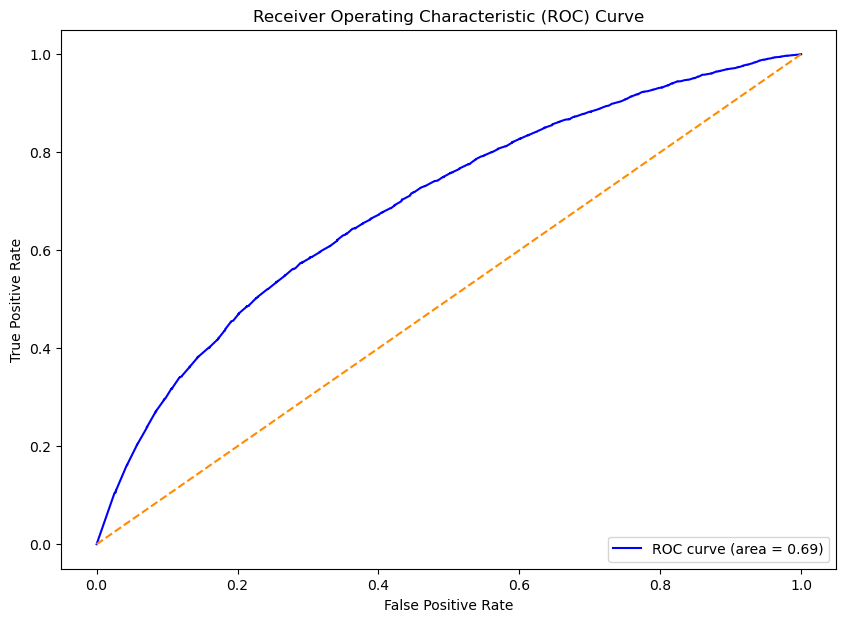

AUC: 0.6928027989624669


In [16]:
# Garder les probabilités pour la classe positive uniquement (généralement classe 1)
rf_probs = rf_probs[:, 1]

# Calculer les scores AUC
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Afficher l'AUC
print("AUC:", roc_auc)

In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
# Calculer l'AUC (Area Under the Curve)

roc_auc = roc_auc_score(test['Label2014'], rf_probs)

In [19]:
roc_auc

0.6928027989624669

In [20]:
tpr

array([0.        , 0.10496032, 0.10515873, ..., 0.99910714, 0.99910714,
       1.        ])

In [21]:
# Créer un DataFrame avec les valeurs de la performance ROC
perf_roc_rf = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Thresholds': thresholds})

# Afficher la performance ROC
print(perf_roc_rf)

           FPR       TPR  Thresholds
0     0.000000  0.000000    2.000000
1     0.025521  0.104960    1.000000
2     0.025521  0.105159    0.998000
3     0.026042  0.105159    0.997500
4     0.027083  0.105556    0.996667
...        ...       ...         ...
1443  0.994271  0.999008    0.008000
1444  0.994531  0.999008    0.007429
1445  0.994792  0.999107    0.005833
1446  0.995313  0.999107    0.001429
1447  1.000000  1.000000    0.000000

[1448 rows x 3 columns]


In [36]:
# Calculer l'AUC (Area Under the Curve)
perf_auc_rf = roc_auc_score(test['Label2014'], rf_probs)

# Afficher l'AUC
print("AUC:", perf_auc_rf)

AUC: 0.6928027989624669


In [22]:
# Extraire les valeurs de FPR, TPR à partir de perf.roc_rf
ROC_df_rf = pd.DataFrame({
    'fpr': perf_roc_rf['FPR'],
    'tpr': perf_roc_rf['TPR']
})

# Afficher le DataFrame
print(ROC_df_rf)

           fpr       tpr
0     0.000000  0.000000
1     0.025521  0.104960
2     0.025521  0.105159
3     0.026042  0.105159
4     0.027083  0.105556
...        ...       ...
1443  0.994271  0.999008
1444  0.994531  0.999008
1445  0.994792  0.999107
1446  0.995313  0.999107
1447  1.000000  1.000000

[1448 rows x 2 columns]


In [43]:
### 
# Create a pipeline with one hot encoding and logistic regression
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', one_hot_encoder, categorical_features)],
    remainder='passthrough')

model_lr = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])

# Fit the model
model_lr.fit(X_train, y_train)

C:\Users\RAZAFIMANANTENA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['Discount', 'Gender',
                                                   'ReductionType'])])),
                ('classifier', LogisticRegression())])

In [46]:
# Generate probability predictions using a logistic regression model
predictions_prob_lr = model_lr.predict(X_test)

In [48]:
predictions_prob_lr

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [49]:
#rename
lr_probs = model_lr.predict_proba(X_test)

In [51]:
lr_probs 

array([[0.3928715 , 0.6071285 ],
       [0.19086895, 0.80913105],
       [0.60209387, 0.39790613],
       ...,
       [0.14254249, 0.85745751],
       [0.49369774, 0.50630226],
       [0.49631186, 0.50368814]])

In [53]:
# Garder les probabilités pour la classe positive uniquement (généralement classe 1)
lr_probs = lr_probs[:, 1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

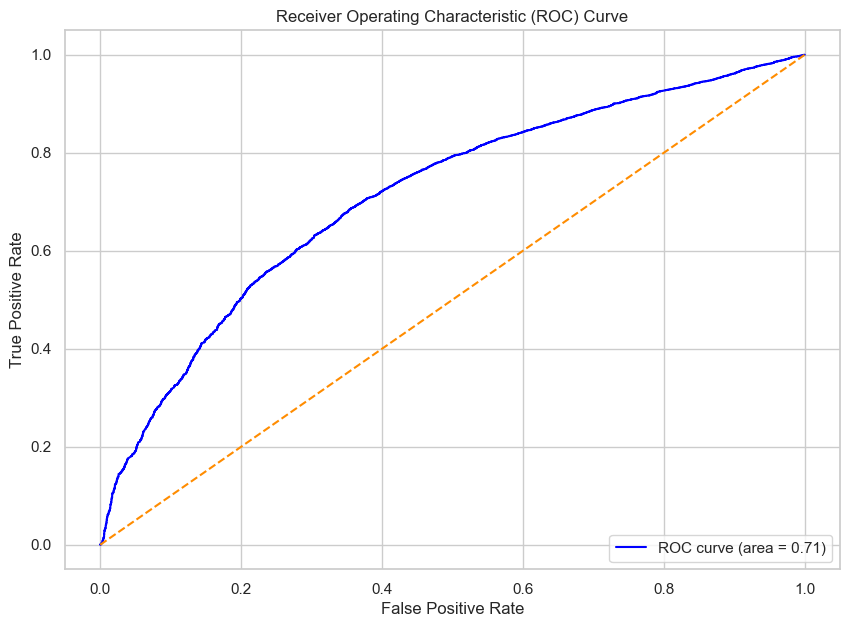

AUC: 0.7118346845031416


In [54]:
# Calculer les scores AUC
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Afficher l'AUC
print("AUC:", roc_auc)

In [65]:
# Create a pipeline with one hot encoding and XGBoost classifier
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', one_hot_encoder, categorical_features)],
    remainder='passthrough')

model_gboost= Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])

# Fit the model
model_gboost.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['Discount', 'Gender',
                                                   'ReductionType'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_c

In [66]:
# Generate probability predictions using a XGBoost model
predictions_prob_gboost = model_gboost.predict(X_test)

In [67]:
predictions_prob_gboost

array([1, 1, 0, ..., 1, 1, 0])

In [68]:
# Rename
gboost_probs = model_gboost.predict_proba(X_test)

In [69]:
gboost_probs

array([[0.24274904, 0.75725096],
       [0.29564673, 0.7043533 ],
       [0.75358135, 0.24641867],
       ...,
       [0.09317994, 0.90682006],
       [0.44906723, 0.55093277],
       [0.5254481 , 0.4745519 ]], dtype=float32)

In [70]:
# Garder les probabilités pour la classe positive uniquement (généralement classe 1)
gboost_probs = gboost_probs[:, 1]

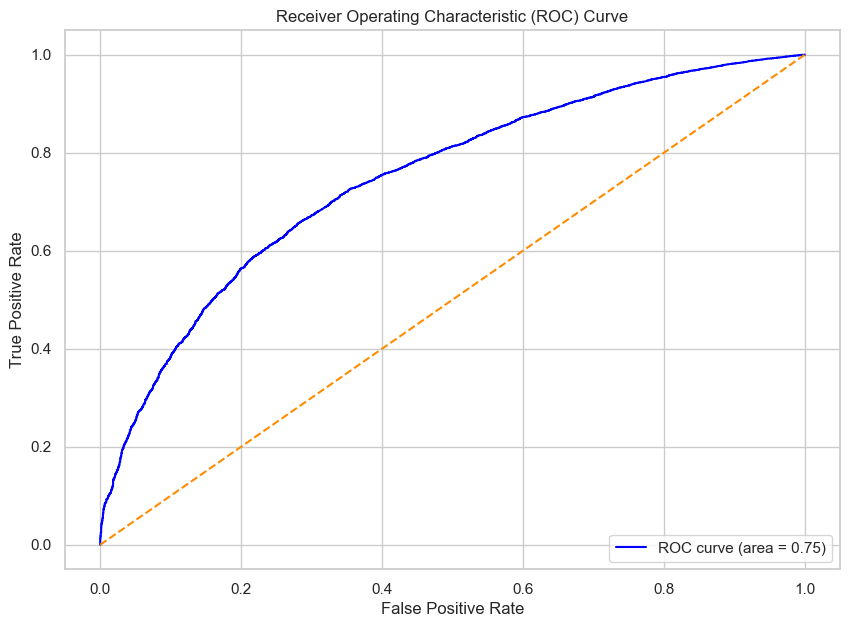

AUC: 0.7469825122974537


In [71]:
# Calculer les scores AUC
fpr, tpr, thresholds = roc_curve(y_test, gboost_probs)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Afficher l'AUC
print("AUC:", roc_auc)

### question 2

In [ ]:
#Make a copy of our original database
testnew = test.copy()

In [25]:
testnew

,Amount,Discount,Gender,ReductionType,interval_visit,Âge,AverageSpending,Label2014
14362,44,MONDADORI CARD,M,ABBONAMENTI MUSEI TORINO,97,61.0,5.125000,1
23731,44,RINNOVO ABBONAMENTO,F,ABBONAMENTI MUSEI TORINO,132,38.0,5.166667,1
26307,30,NESSUNO SCONTO,F,ABBONAMENTO MUSEI RIDOTTO,165,23.0,5.500000,0
14361,49,NESSUNO SCONTO,F,ABBONAMENTI MUSEI TORINO,0,37.0,5.375000,1
39286,30,NESSUNO SCONTO,F,ABBONAMENTO MUSEI RIDOTTO,38,44.0,4.156250,0
...,...,...,...,...,...,...,...,...
24349,28,RINNOVO ABBONAMENTO,M,ABBONAMENTO MUSEI RIDOTTO,13,72.0,3.500000,1
14356,44,RINNOVO ABBONAMENTO,F,ABBONAMENTI MUSEI TORINO,61,40.0,3.500000,1
54175,28,RINNOVO ABBONAMENTO,F,ABBONAMENTO MUSEI RIDOTTO,11,44.0,4.608696,1
46835,49,NESSUNO SCONTO,M,ABBONAMENTI MUSEI TORINO,32,44.0,5.111111,0


In [26]:
# Convert 'default.payment.next.month' column to numeric
testnew['Label2014'] = pd.to_numeric(testnew['Label2014'])


In [27]:
testnew

,Amount,Discount,Gender,ReductionType,interval_visit,Âge,AverageSpending,Label2014
14362,44,MONDADORI CARD,M,ABBONAMENTI MUSEI TORINO,97,61.0,5.125000,1
23731,44,RINNOVO ABBONAMENTO,F,ABBONAMENTI MUSEI TORINO,132,38.0,5.166667,1
26307,30,NESSUNO SCONTO,F,ABBONAMENTO MUSEI RIDOTTO,165,23.0,5.500000,0
14361,49,NESSUNO SCONTO,F,ABBONAMENTI MUSEI TORINO,0,37.0,5.375000,1
39286,30,NESSUNO SCONTO,F,ABBONAMENTO MUSEI RIDOTTO,38,44.0,4.156250,0
...,...,...,...,...,...,...,...,...
24349,28,RINNOVO ABBONAMENTO,M,ABBONAMENTO MUSEI RIDOTTO,13,72.0,3.500000,1
14356,44,RINNOVO ABBONAMENTO,F,ABBONAMENTI MUSEI TORINO,61,40.0,3.500000,1
54175,28,RINNOVO ABBONAMENTO,F,ABBONAMENTO MUSEI RIDOTTO,11,44.0,4.608696,1
46835,49,NESSUNO SCONTO,M,ABBONAMENTI MUSEI TORINO,32,44.0,5.111111,0


In [28]:
# Calculate profit based on the provided formula
testnew['profit'] = testnew['Label2014'] * 9.8 - (1 - testnew['Label2014']) *(testnew['Amount'] +0.2-10)


In [29]:
testnew

,Amount,Discount,Gender,ReductionType,interval_visit,Âge,AverageSpending,Label2014,profit
14362,44,MONDADORI CARD,M,ABBONAMENTI MUSEI TORINO,97,61.0,5.125000,1,9.8
23731,44,RINNOVO ABBONAMENTO,F,ABBONAMENTI MUSEI TORINO,132,38.0,5.166667,1,9.8
26307,30,NESSUNO SCONTO,F,ABBONAMENTO MUSEI RIDOTTO,165,23.0,5.500000,0,-20.2
14361,49,NESSUNO SCONTO,F,ABBONAMENTI MUSEI TORINO,0,37.0,5.375000,1,9.8
39286,30,NESSUNO SCONTO,F,ABBONAMENTO MUSEI RIDOTTO,38,44.0,4.156250,0,-20.2
...,...,...,...,...,...,...,...,...,...
24349,28,RINNOVO ABBONAMENTO,M,ABBONAMENTO MUSEI RIDOTTO,13,72.0,3.500000,1,9.8
14356,44,RINNOVO ABBONAMENTO,F,ABBONAMENTI MUSEI TORINO,61,40.0,3.500000,1,9.8
54175,28,RINNOVO ABBONAMENTO,F,ABBONAMENTO MUSEI RIDOTTO,11,44.0,4.608696,1,9.8
46835,49,NESSUNO SCONTO,M,ABBONAMENTI MUSEI TORINO,32,44.0,5.111111,0,-39.2


In [31]:
# RF
testnew['rf_prediction'] = rf_probs
testnew['rf_rank'] = testnew['rf_prediction'].rank(ascending=False, method='first')
testnew['cumsum_rf'] = testnew['profit'].cumsum()

In [55]:
##lR
testnew['lr_rank'] = testnew['lr_prediction'].rank(ascending=False, method='first')
testnew['lr_prediction'] = lr_probs
testnew['cumsum_lr'] = testnew['profit'].cumsum()

In [72]:
#XGBOOST
testnew['gboost_prediction'] = gboost_probs
testnew['gboost_rank'] = testnew['gboost_prediction'].rank(ascending=False, method='first')
testnew['cumsum_gboost'] = testnew['profit'].cumsum()

In [85]:
testnew

,Amount,Discount,Gender,ReductionType,interval_visit,Âge,AverageSpending,Label2014,profit,rf_prediction,rf_rank,cumsum_rf,lr_prediction,lr_rank,cumsum_lr,gboost_prediction,gboost_rank,cumsum_gboost
14362,44,MONDADORI CARD,M,ABBONAMENTI MUSEI TORINO,97,61.0,5.125000,1,9.8,0.630,9456.0,9.8,0.607128,9939.0,9.8,0.757251,7067.0,9.8
23731,44,RINNOVO ABBONAMENTO,F,ABBONAMENTI MUSEI TORINO,132,38.0,5.166667,1,9.8,0.780,6938.0,19.6,0.809131,6513.0,19.6,0.704353,8260.0,19.6
26307,30,NESSUNO SCONTO,F,ABBONAMENTO MUSEI RIDOTTO,165,23.0,5.500000,0,-20.2,0.250,13130.0,-0.6,0.397906,13821.0,-0.6,0.246419,13792.0,-0.6
14361,49,NESSUNO SCONTO,F,ABBONAMENTI MUSEI TORINO,0,37.0,5.375000,1,9.8,0.356,12380.0,9.2,0.512784,12036.0,9.2,0.432811,12637.0,9.2
39286,30,NESSUNO SCONTO,F,ABBONAMENTO MUSEI RIDOTTO,38,44.0,4.156250,0,-20.2,0.190,13420.0,-11.0,0.544448,10943.0,-11.0,0.530907,11418.0,-11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24349,28,RINNOVO ABBONAMENTO,M,ABBONAMENTO MUSEI RIDOTTO,13,72.0,3.500000,1,9.8,0.980,2239.0,391.8,0.902637,699.0,391.8,0.964828,455.0,391.8
14356,44,RINNOVO ABBONAMENTO,F,ABBONAMENTI MUSEI TORINO,61,40.0,3.500000,1,9.8,0.870,5301.0,401.6,0.826282,5941.0,401.6,0.773728,6731.0,401.6
54175,28,RINNOVO ABBONAMENTO,F,ABBONAMENTO MUSEI RIDOTTO,11,44.0,4.608696,1,9.8,0.980,2240.0,411.4,0.857458,2101.0,411.4,0.906820,2350.0,411.4
46835,49,NESSUNO SCONTO,M,ABBONAMENTI MUSEI TORINO,32,44.0,5.111111,0,-39.2,0.150,13588.0,372.2,0.506302,12265.0,372.2,0.550933,11077.0,372.2


Text(0, 0.5, 'Cumulative profit ')

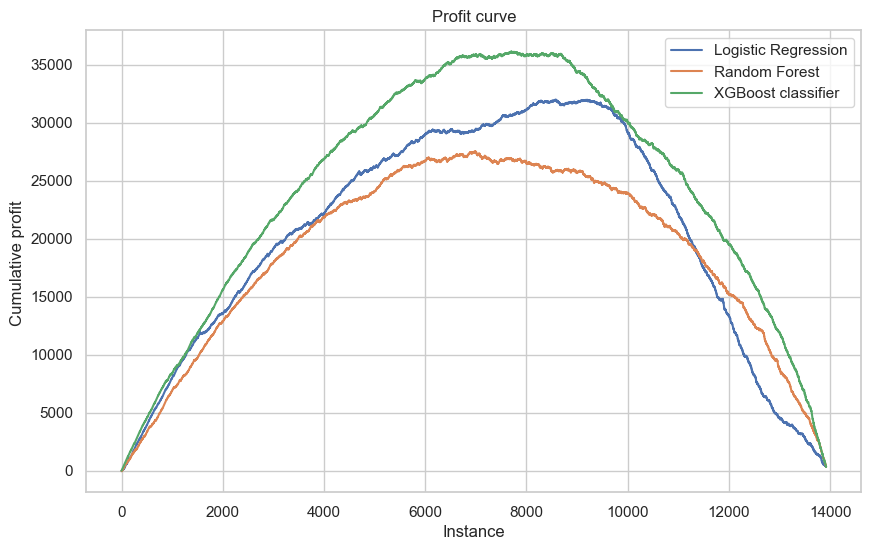

In [84]:
##plot the cumulative profit curve for each model
sns.set(style='whitegrid')
fig, ax=plt.subplots(figsize=(10,6))
ax.plot(testnew['lr_rank'].sort_values(ascending=True),testnew.sort_values(by='lr_rank',ascending=True)
        ['profit'].cumsum(), label='Logistic Regression')
ax.plot(testnew['rf_rank'].sort_values(ascending=True),testnew.sort_values(by='rf_rank',ascending=True)
        ['profit'].cumsum(), label='Random Forest')
ax.plot(testnew['gboost_rank'].sort_values(ascending=True),testnew.sort_values(by='gboost_rank',ascending=True)
        ['profit'].cumsum(), label='XGBoost classifier')
ax.legend(loc='upper right')
ax.set_title("Profit curve")
ax.set_xlabel("Instance")
ax.set_ylabel("Cumulative profit ")